In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

custom_colors = ["#c8e7ff","#deaaff", "#f72585","#d100d1"]

In [108]:
# Load the data
df = pd.read_csv('data/Preprocessed data.csv')
df.head()

,"Q1r1 - To begin, what is your age?",QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,...,Q89 - Which of the following is your most frequently used mechanism to get news?_I do not follow the news,Q89 - Which of the following is your most frequently used mechanism to get news?_Magazine,Q89 - Which of the following is your most frequently used mechanism to get news?_News aggregators,Q89 - Which of the following is your most frequently used mechanism to get news?_Online news sites not associated with a traditional news organization,Q89 - Which of the following is your most frequently used mechanism to get news?_Online version of newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Print newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Radio,Q89 - Which of the following is your most frequently used mechanism to get news?_Social media sites,Q89 - Which of the following is your most frequently used mechanism to get news?_Television news stations,Q89 - Which of the following is your most frequently used mechanism to get news?_Variety/talk shows
0,26.0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,25.0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,28.0,1,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,16.0,1,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,32.0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0


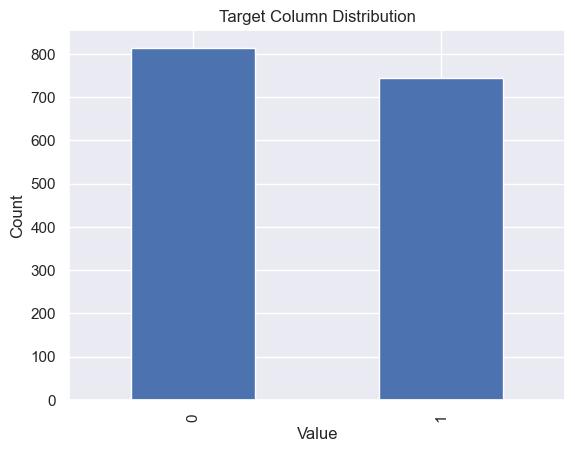

In [109]:
target_col = 'Q29 - You said that you subscribe to home Internet access, how much more would you be willing to pay to receive double your download speed?'

df.drop(columns="Q26 - Which of the following subscriptions does your household purchase?-Home internet", inplace=True)

# Count the number of occurrences of each unique value in the target column
counts = df[target_col].value_counts()

# Create a bar plot of the counts
counts.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Target Column Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.show()

In [111]:
def train_model(X, y, model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_accs = []
    test_accs = []
    predicted_targets = np.array([])
    actual_targets = np.array([])

    for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_predictions)
        test_acc = accuracy_score(y_test, test_predictions)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        predicted_targets = np.append(predicted_targets, test_predictions)
        actual_targets = np.append(actual_targets, y_test)

    return train_accs, test_accs, predicted_targets, actual_targets

X = df.drop(target_col, axis=1)
y = df[target_col]

models = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("SVM", SVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Decision Tree", BaggingClassifier(base_estimator=DecisionTreeClassifier())),
    ("Boosted Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Decision Tree - d1", DecisionTreeClassifier(max_depth=1)),
    ("Decision Tree - d2", DecisionTreeClassifier(max_depth=2)),
    ("Decision Tree - d3", DecisionTreeClassifier(max_depth=3)),
    ("Decision Tree - d4", DecisionTreeClassifier(max_depth=4)),
    ("Bagging Decision Tree - d2", BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))),
    ("Boosted Decision Tree - d2", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))),
    ("Random Forest", RandomForestClassifier()),
    ("Voting Classification", VotingClassifier(estimators=[('lr', LogisticRegression()), ('knn', KNeighborsClassifier()), ('svc', SVC()), ('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier())])),
    ("Neural Network", MLPClassifier())
]

for name, model in models:

    train_accs, test_accs, predicted_targets, actual_targets = train_model(X, y, model)

    # calculating the average accuracy over all folds for each model
    train_avg_acc = np.mean(train_accs)
    test_avg_acc = np.mean(test_accs)

    print("\n" + name +  " Accuracy (Train) across all folds: ", train_avg_acc)
    print( name +  " Accuracy (Test) across all folds: ", test_avg_acc)


Naive Bayes Accuracy (Train) across all folds:  0.7439036351770734
Naive Bayes Accuracy (Test) across all folds:  0.7195461291120455

Logistic Regression Accuracy (Train) across all folds:  0.7033069414749492
Logistic Regression Accuracy (Test) across all folds:  0.6951459312391789

KNN Accuracy (Train) across all folds:  0.7865854616086634
KNN Accuracy (Test) across all folds:  0.7002597081375216

SVM Accuracy (Train) across all folds:  0.5738149085896038
SVM Accuracy (Test) across all folds:  0.5738498639624041

Decision Tree Accuracy (Train) across all folds:  1.0
Decision Tree Accuracy (Test) across all folds:  0.6643148651991095

Bagging Decision Tree Accuracy (Train) across all folds:  0.9862005892794393
Bagging Decision Tree Accuracy (Test) across all folds:  0.7008904279000742

Boosted Decision Tree Accuracy (Train) across all folds:  1.0
Boosted Decision Tree Accuracy (Test) across all folds:  0.6713620248990024

Decision Tree - d1 Accuracy (Train) across all folds:  0.710848

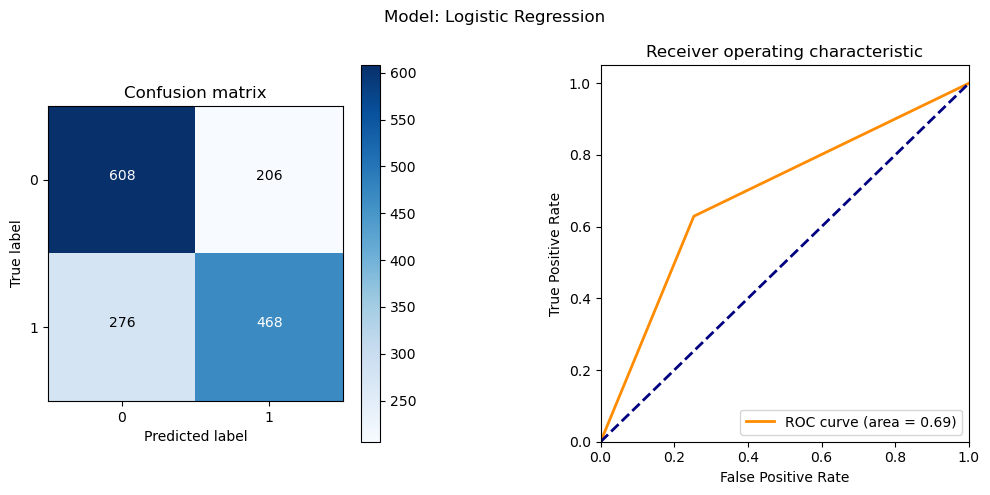

In [5]:
class_names = [0, 1]
train_accs, test_accs, predicted_targets, actual_targets  = train_model(X, y, models[1][1])
cm = confusion_matrix(actual_targets, predicted_targets)

classes = [0,1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot confusion matrix
im = ax[0].imshow(cm, cmap=plt.get_cmap('Blues'))
ax[0].set_title("Confusion matrix")
fig.colorbar(im, ax=ax[0])

tick_marks = np.arange(len(classes))
ax[0].set_xticks(tick_marks)
ax[0].set_xticklabels(classes)
ax[0].set_yticks(tick_marks)
ax[0].set_yticklabels(classes)
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

fmt = 'd'
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax[0].text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# Calculate precision, recall, and F1 score, AUC-ROC score
precision = precision_score(actual_targets, predicted_targets)
recall = recall_score(actual_targets, predicted_targets)
f1 = f1_score(actual_targets, predicted_targets)

# Plot ROC curve
fpr, tpr, _ = roc_curve(actual_targets, predicted_targets)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")

plt.suptitle("Model: Logistic Regression")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [6]:
# Create a logistic regression model
lr = LogisticRegression()

# Perform k-fold cross-validation with permutation feature importance
cv_results = cross_validate(lr, X, y, cv=5, scoring='accuracy',
                            return_estimator=True, return_train_score=True)

# Compute permutation feature importance for each fold
importance_scores = []
for estimator in cv_results['estimator']:
    result = permutation_importance(estimator, X, y, scoring='accuracy',
                                    n_repeats=10, random_state=0)
    importance_scores.append(result.importances_mean)

# Aggregate feature importance scores across folds
mean_importance = np.mean(importance_scores, axis=0)
std_importance = np.std(importance_scores, axis=0)

# Sort features by mean importance score
feature_importance = sorted(zip(X.columns, mean_importance, std_importance),
                            key=lambda x: x[1], reverse=True)

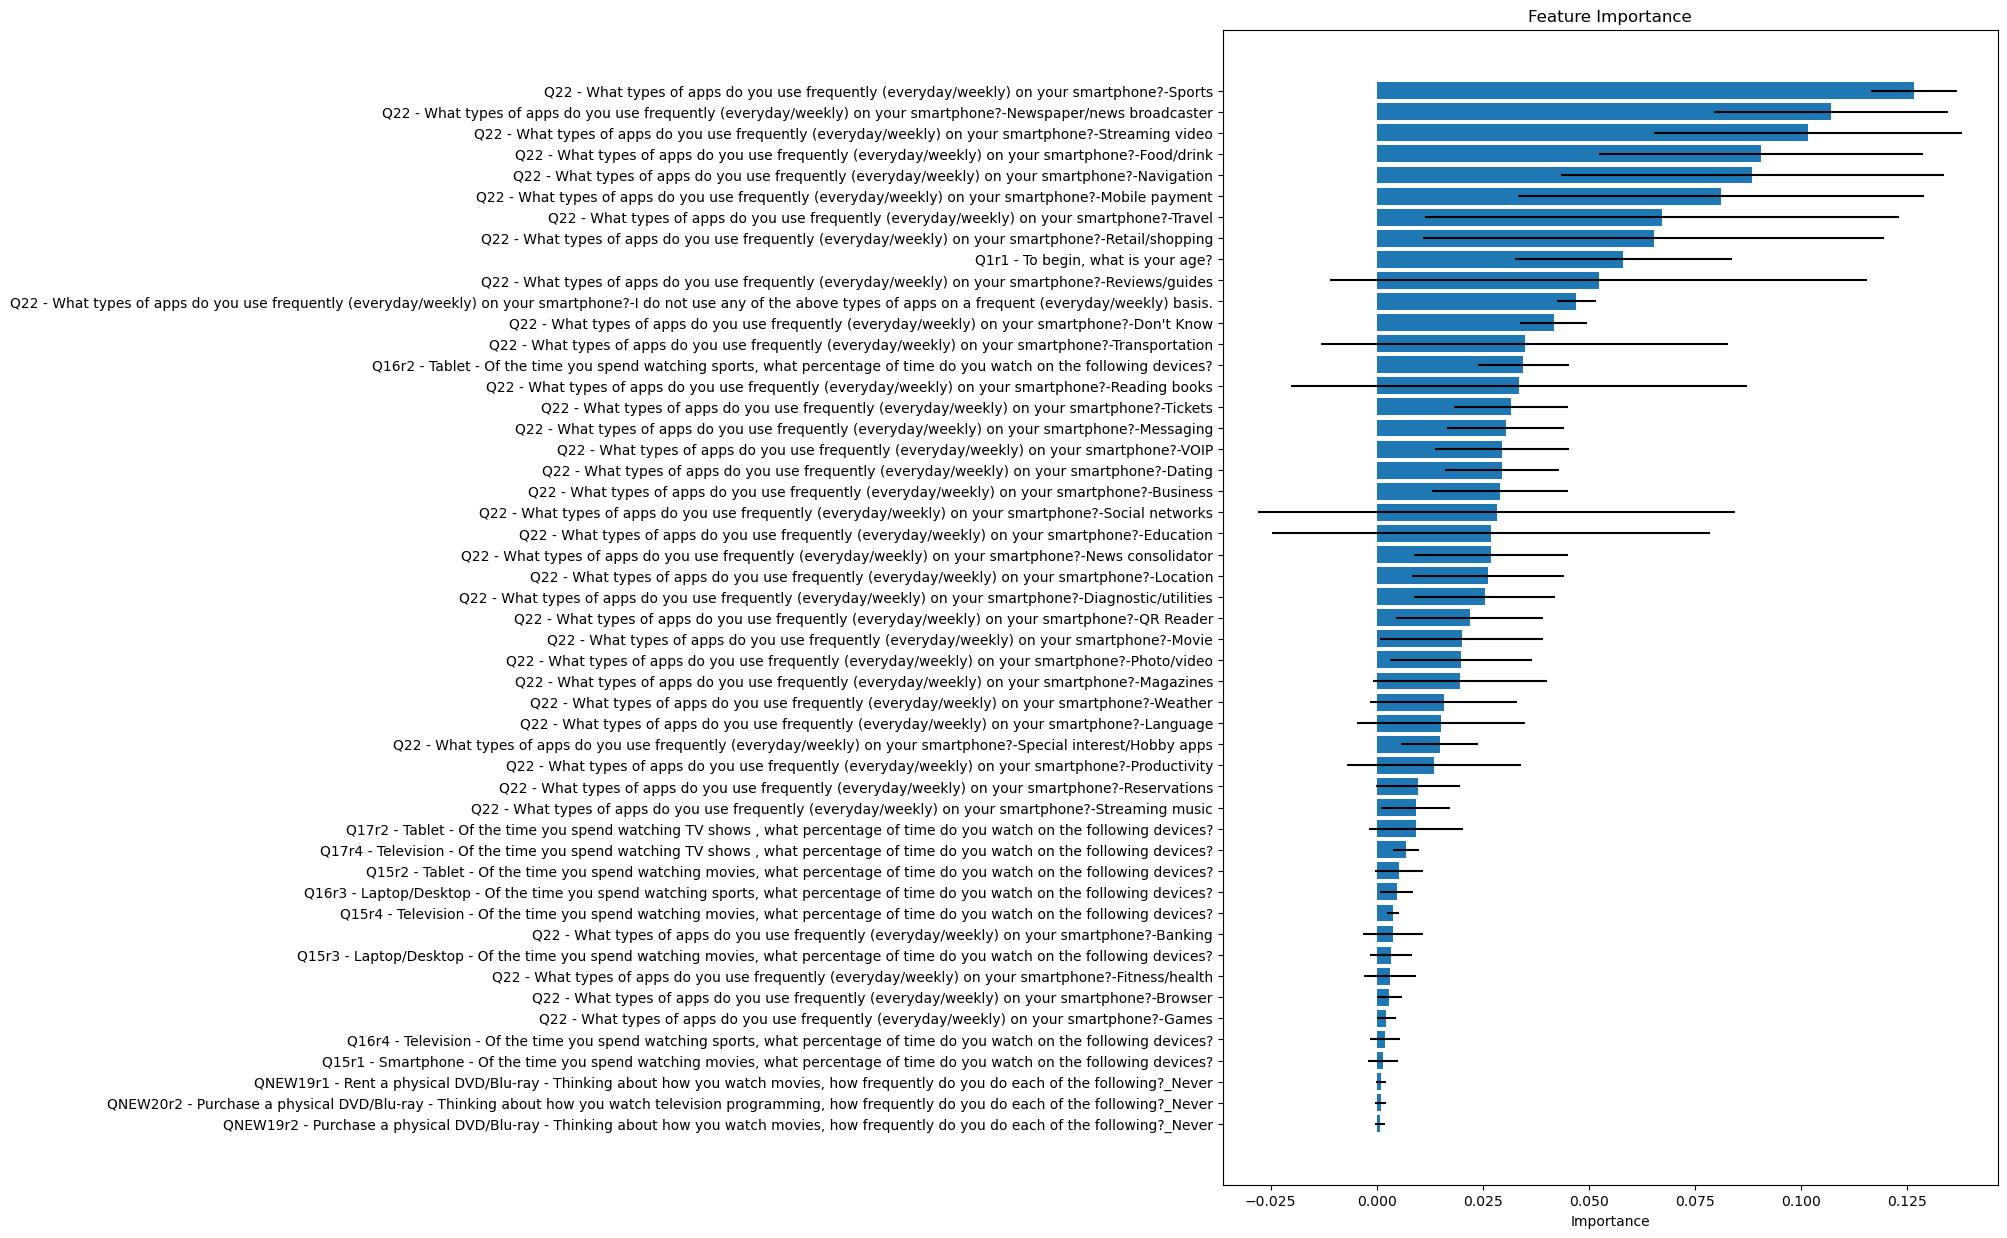

In [7]:
# Get feature names and importance scores
features = [f[0] for f in feature_importance[:50]]
importance = [f[1] for f in feature_importance[:50]]
std = [f[2] for f in feature_importance[:50]]

# Plot feature importance as a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(features, importance, xerr=std, align='center')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [8]:
df.drop(target_col, axis=1)

,"Q1r1 - To begin, what is your age?",QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,...,Q89 - Which of the following is your most frequently used mechanism to get news?_I do not follow the news,Q89 - Which of the following is your most frequently used mechanism to get news?_Magazine,Q89 - Which of the following is your most frequently used mechanism to get news?_News aggregators,Q89 - Which of the following is your most frequently used mechanism to get news?_Online news sites not associated with a traditional news organization,Q89 - Which of the following is your most frequently used mechanism to get news?_Online version of newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Print newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Radio,Q89 - Which of the following is your most frequently used mechanism to get news?_Social media sites,Q89 - Which of the following is your most frequently used mechanism to get news?_Television news stations,Q89 - Which of the following is your most frequently used mechanism to get news?_Variety/talk shows
0,26.0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,25.0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,28.0,1,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,16.0,1,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,32.0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,14.0,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1554,70.0,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1555,18.0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1556,79.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


For n_clusters =  2 , the average silhouette_score is:  0.977086855356854


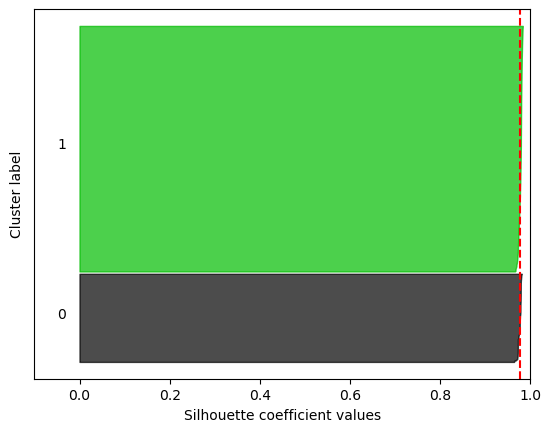

For n_clusters =  3 , the average silhouette_score is:  0.5520303488179387


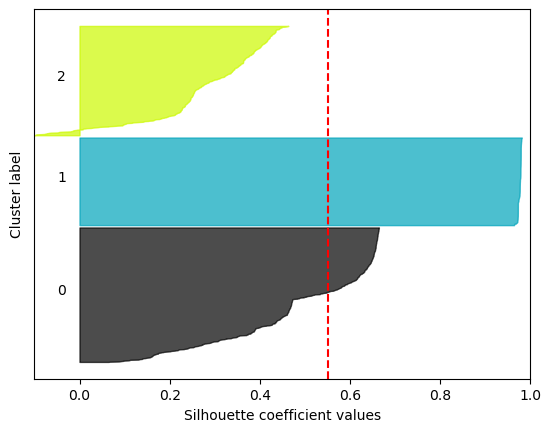

For n_clusters =  4 , the average silhouette_score is:  0.4179110813683998


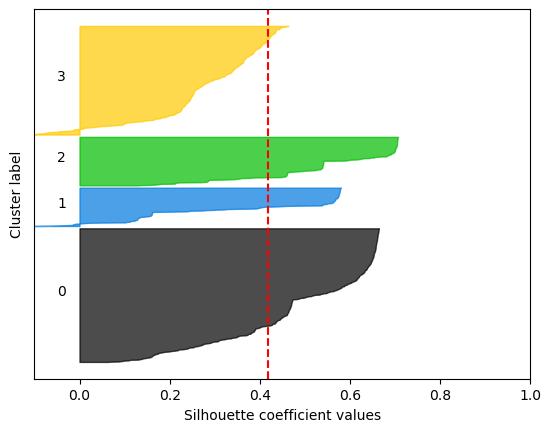

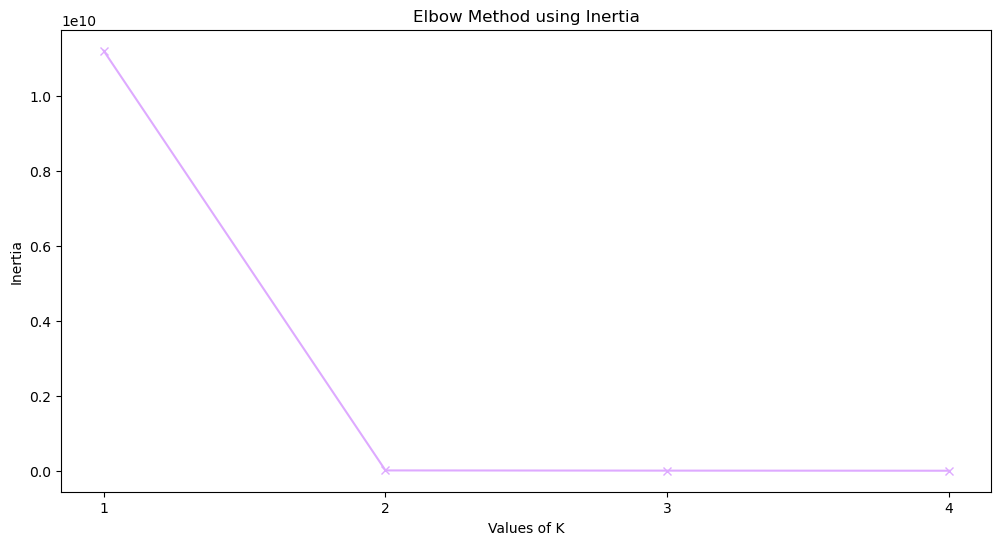

In [9]:
inertias = [] 

for n_clusters in range(1, 5):

    # elbow method
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state= 42)
    kmeans.fit(df)
    labels = kmeans.labels_ 
    inertias.append(kmeans.inertia_) 

    # silhouette analysis
    if n_clusters!=1:
        # calculating the overall silhouette score
        silhouette_avg = silhouette_score(df, kmeans.labels_)

        print(
        "For n_clusters = ",
        n_clusters,
        ", the average silhouette_score is: ",
        silhouette_avg)

        # calculating the silhouette scores for each data point
        sample_silhouette_values = silhouette_samples(df, kmeans.labels_)

        # plotting the silhouette scores as a horizontal bar chart
        fig, ax = plt.subplots()
        y_lower = 10
        for i in range(n_clusters):
            # aggregating the silhouette scores for samples belonging to cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]

            # sorting the silhouette scores for the samples in this cluster
            ith_cluster_silhouette_values.sort()

            # computing the size of the cluster and set the upper y coordinate for this cluster's silhouette plot
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # creating the color map for the cluster
            color = plt.cm.nipy_spectral(float(i) / n_clusters)

            # plotting the silhouette scores for the samples in this cluster
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # labelling the silhouette plot with the cluster number
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # computing the new y_lower for the next plot
            y_lower = y_upper + 10

        # setting the plot parameters
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        # clearing the yaxis labels / ticks
        ax.set_yticks([])  

        ax.set_xlim([-0.1, 1])

        plt.show()

# plotting Elbow method using Inertia
plt.figure(figsize=(12,6))
plt.plot(range(1, 5), inertias, 'bx-',color=custom_colors[1]) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.xticks(range(1, 5))
plt.title('Elbow Method using Inertia') 
plt.show() 

In [10]:
# performing k-means with the number of clusters specified as 2
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state= 42)
kmeans.fit(df)

KMeans(n_clusters=2, random_state=42)

In [11]:
# combining all the relevant columns
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(kmeans.labels_, columns=['Cluster'])], axis=1)
df.head()

,"Q1r1 - To begin, what is your age?",QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,...,Q89 - Which of the following is your most frequently used mechanism to get news?_Magazine,Q89 - Which of the following is your most frequently used mechanism to get news?_News aggregators,Q89 - Which of the following is your most frequently used mechanism to get news?_Online news sites not associated with a traditional news organization,Q89 - Which of the following is your most frequently used mechanism to get news?_Online version of newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Print newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Radio,Q89 - Which of the following is your most frequently used mechanism to get news?_Social media sites,Q89 - Which of the following is your most frequently used mechanism to get news?_Television news stations,Q89 - Which of the following is your most frequently used mechanism to get news?_Variety/talk shows,Cluster
0,26.0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,25.0,1,1,1,0,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,1
2,28.0,1,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,16.0,1,1,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
4,32.0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,1


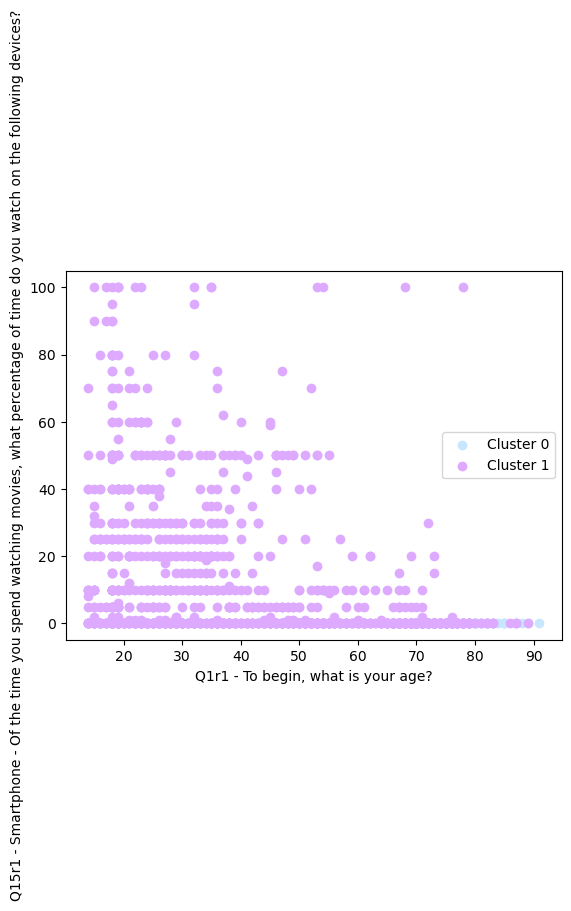

In [12]:
# plotting 2 health outcome columns by cluster
fig, ax = plt.subplots()

col1 = 'Q1r1 - To begin, what is your age?'
col2 = 'Q15r1 - Smartphone - Of the time you spend watching movies, what percentage of time do you watch on the following devices?'

for i, group in df.groupby('Cluster'):
    ax.scatter(group[col1], group[col2], color=custom_colors[i], label=f'Cluster {i}')

ax.set_xlabel(col1)
ax.set_ylabel(col2)
ax.legend()

plt.show()